In [100]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.io_utils as io_utils
import matching.glema.common.utils.model_utils as model_utils
import matching.glema.evaluation.evaluate_pattern_matching as epm
import matching.misc.cpg_const as cpg_const
from matching.glema.common.utils.plot_utils import ColorScheme

In [101]:
args = arg_utils.parse_args( use_default=True )
args.dataset = "dpdf"
args.directed = False
args.anchored = True
version = model_utils.get_latest_model_version( args )
model_name = model_utils.get_model_name( args, version )

result_dir = os.path.join( args.result_dir, model_name )
subgraph_matching_file = io_utils.get_abs_file_path( os.path.join( result_dir, "result.csv" ) )
pattern_matching_file = io_utils.get_abs_file_path( os.path.join( result_dir, "result_pattern_matching.csv" ) )
pattern_matching_sources_file = io_utils.get_abs_file_path(
    os.path.join( result_dir, "result_pattern_matching_sources.csv" ) )

In [102]:
subgraph_matching_df = pd.read_csv( subgraph_matching_file )
pattern_matching_df = pd.read_csv( pattern_matching_file )
source_pred_df = pd.read_csv( pattern_matching_sources_file, na_filter=False )

In [103]:
DESIGN_PATTERN_MAPPING = {
    cpg_const.DesignPatternType.ABSTRACT_FACTORY.value: "Abstract Factory",
    cpg_const.DesignPatternType.ADAPTER.value: "Adapter",
    cpg_const.DesignPatternType.BUILDER.value: "Builder",
    cpg_const.DesignPatternType.FACADE.value: "Facade",
    cpg_const.DesignPatternType.FACTORY_METHOD.value: "Factory Method",
    cpg_const.DesignPatternType.OBSERVER.value: "Observer",
    cpg_const.DesignPatternType.SINGLETON.value: "Singleton",
    cpg_const.DesignPatternType.DECORATOR.value: "Decorator",
    cpg_const.DesignPatternType.MEMENTO.value: "Memento",
    cpg_const.DesignPatternType.PROTOTYPE.value: "Prototype",
    cpg_const.DesignPatternType.PROXY.value: "Proxy",
    cpg_const.DesignPatternType.VISITOR.value: "Visitor",
    cpg_const.NO_DESIGN_PATTERN: "None",
}

DATASET_KEY = "dataset"
RECORD_KEY = "record"
TRUE_KEY = "true_type"
PRED_KEY = "pred_type"
PRED_SCORE_KEY = "pred_score"

CONFIDENCE_KEY = "Confident"
TIME_KEY = "Execution Time"
ROC_KEY = "ROC AUC"
PR_KEY = "PR AUC"
PREC_KEY = "Precision"
REC_KEY = "Recall"
F1_KEY = "F1-Score"
ACC_KEY = "Accuracy"

METRIC_COMPUTE_MAPPING = {
    ROC_KEY: "roc",
    PR_KEY: "avp",
    PREC_KEY: "pre",
    REC_KEY: "rec",
    F1_KEY: "f1s",
    ACC_KEY: "acc"
}

KEY_MAPPING = {
    DATASET_KEY: "Project",
    RECORD_KEY: "Record",
    TRUE_KEY: "True Pattern",
    PRED_KEY: "Predicted Pattern",
    PRED_SCORE_KEY: "Prediction Score",
    CONFIDENCE_KEY: "Confidence",
    TIME_KEY: "Runtime (s)",
    ROC_KEY: "ROC AUC",
    PR_KEY: "PR AUC",
    PREC_KEY: "Precision",
    REC_KEY: "Recall",
    F1_KEY: "F1-Score",
    ACC_KEY: "Accuracy",
}

## Confusion Matrix

In [104]:
source_pred_df

,gidx,dataset,record,true_type,pred_type,pred_score
0,394,p_mart-11_-_pmd_v18,test.net.sourceforge.pmd.cpd.JavaTokensTokeniz...,N/A,VISITOR,0.367907
1,428,p_mart-11_-_pmd_v18,test.net.sourceforge.pmd.symboltable.NameOccur...,N/A,VISITOR,0.367907
2,1022,p_mart-10_-_nutch_v04,net.nutch.db.DistributedWebDBWriter.LinkInstru...,N/A,VISITOR,0.609831
3,397,p_mart-11_-_pmd_v18,net.sourceforge.pmd.PMDException,N/A,VISITOR,0.367936
4,1084,p_mart-10_-_nutch_v04,net.nutch.db.WebDBWriter.DeduplicatingPageSequ...,N/A,VISITOR,0.609703
...,...,...,...,...,...,...
70,112,p_mart-5_-_junit_v37,junit.extensions.TestDecorator,DECORATOR,DECORATOR,0.883315
71,17,p_mart-5_-_junit_v37,junit.extensions.TestSetup,DECORATOR,DECORATOR,0.527402
72,26,p_mart-5_-_junit_v37,junit.extensions.RepeatedTest,DECORATOR,DECORATOR,0.527402
73,584,p_mart-8_-_mapperxml_v197,com.taursys.servlet.ServletForm,FACADE,FACADE,0.870310


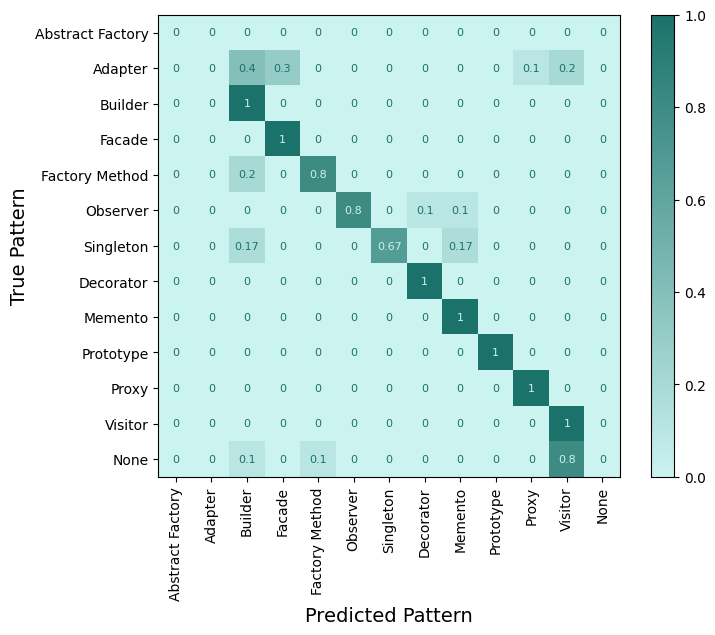

In [105]:
def compute_pred_cm( true_labels: list[ str ], pred_labels: list[ str ], file_name,
                     labels=None, include_na=True ):
    if labels is None:
        labels = [ dp.value for dp in cpg_const.DesignPatternType ]
    if include_na:
        labels = [ *labels, cpg_const.NO_DESIGN_PATTERN ]

    cm = confusion_matrix( true_labels, pred_labels, labels=labels, normalize="true" )
    cm = np.round( cm, 2 )

    display_labels = [ DESIGN_PATTERN_MAPPING[ label ] for label in labels ]
    fig, ax = plt.subplots( figsize=(8, 6) )
    disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=display_labels )

    cmap = LinearSegmentedColormap.from_list( "custom_cmap", [
        ColorScheme.SECONDARY_LIGHT,
        ColorScheme.SECONDARY_DARK ] )
    disp.plot( cmap=cmap, ax=ax, colorbar=True )

    for text in disp.text_.ravel():
        text.set_fontsize( 8 )
    plt.xlabel( KEY_MAPPING[ PRED_KEY ], fontsize=14 )
    plt.ylabel( KEY_MAPPING[ TRUE_KEY ], fontsize=14 )
    plt.xticks( fontsize=10, rotation=90 )
    plt.yticks( fontsize=10 )

    plt.savefig( f"plots/{file_name}", bbox_inches='tight', pad_inches=0.1 )


pattern_types = [
    cpg_const.DesignPatternType.BUILDER.value,
    cpg_const.DesignPatternType.DECORATOR.value
]
pattern_types = None
true_labels = source_pred_df[ TRUE_KEY ].to_list()
pred_labels = source_pred_df[ PRED_KEY ].to_list()
compute_pred_cm( true_labels, pred_labels, "matching_cm", labels=pattern_types, include_na=True )

## Metric Value Progress 

In [106]:
subgraph_matching_df

,Confident,Execution Time,ROC AUC,PR AUC,Precision,Recall,F1-Score,Accuracy
0,0.50,0.000496,0.879406,0.861618,0.951431,0.800030,0.869187,0.879042
1,0.60,0.000496,0.865559,0.849810,0.955023,0.767603,0.851117,0.865109
2,0.70,0.000496,0.847597,0.833972,0.958597,0.726879,0.826810,0.847043
3,0.80,0.000496,0.823421,0.812328,0.963022,0.672919,0.792249,0.822730
4,0.90,0.000496,0.780099,0.772464,0.968991,0.578894,0.724787,0.779175
5,0.91,0.000496,0.773359,0.766202,0.969870,0.564413,0.713568,0.772399
6,0.92,0.000496,0.765554,0.758894,0.970729,0.547779,0.700352,0.764554
7,0.93,0.000496,0.755421,0.749400,0.971899,0.526197,0.682747,0.754368
8,0.94,0.000496,0.744143,0.738846,0.973367,0.502153,0.662518,0.743032
9,0.95,0.000496,0.728824,0.724322,0.974765,0.469926,0.634139,0.727635


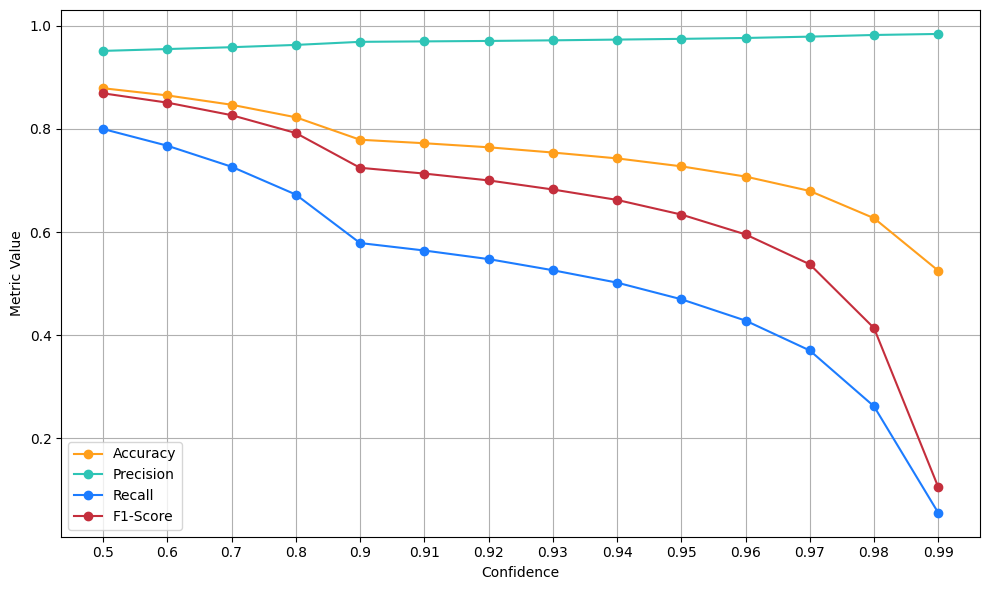

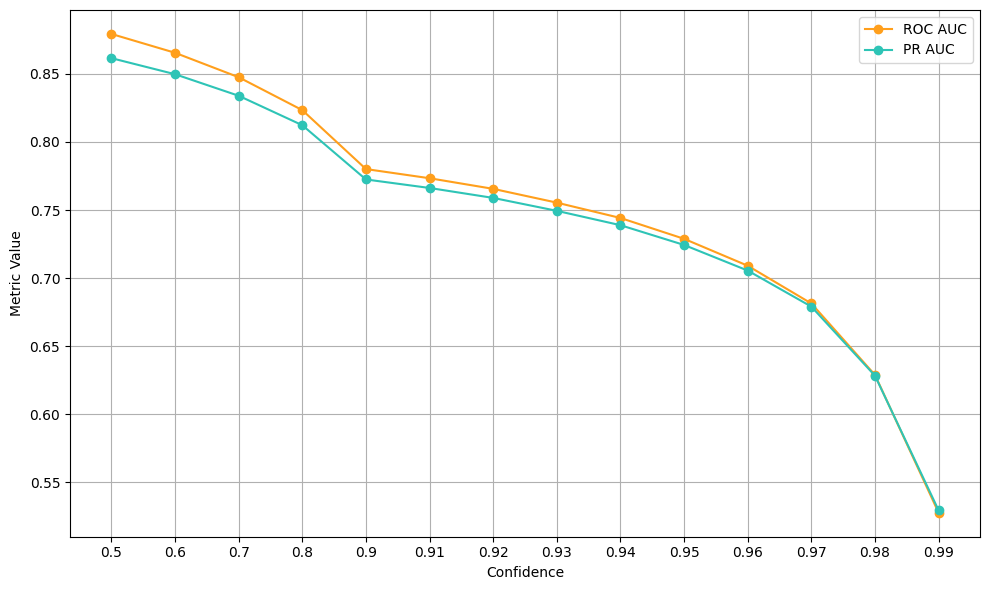

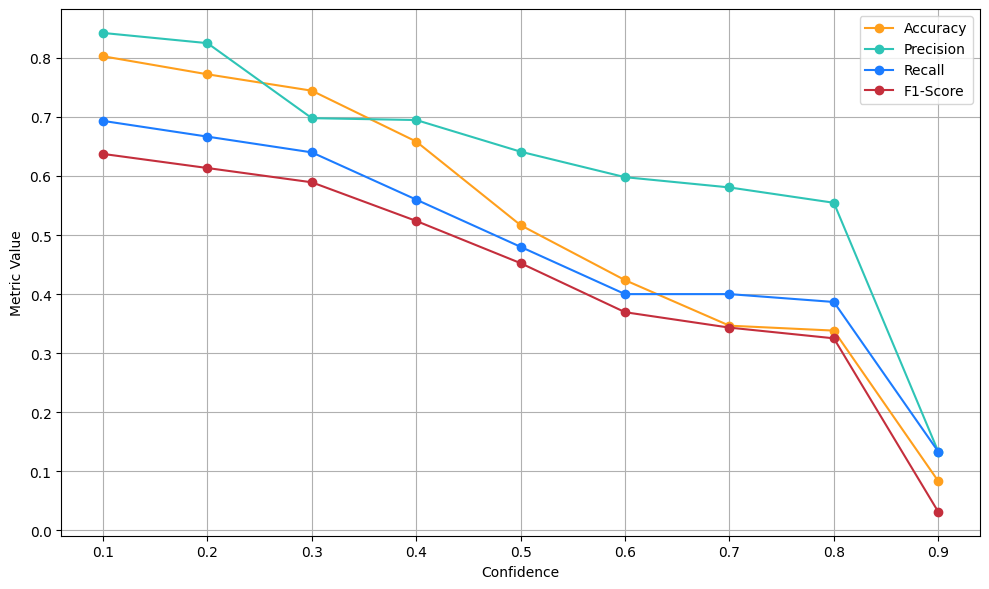

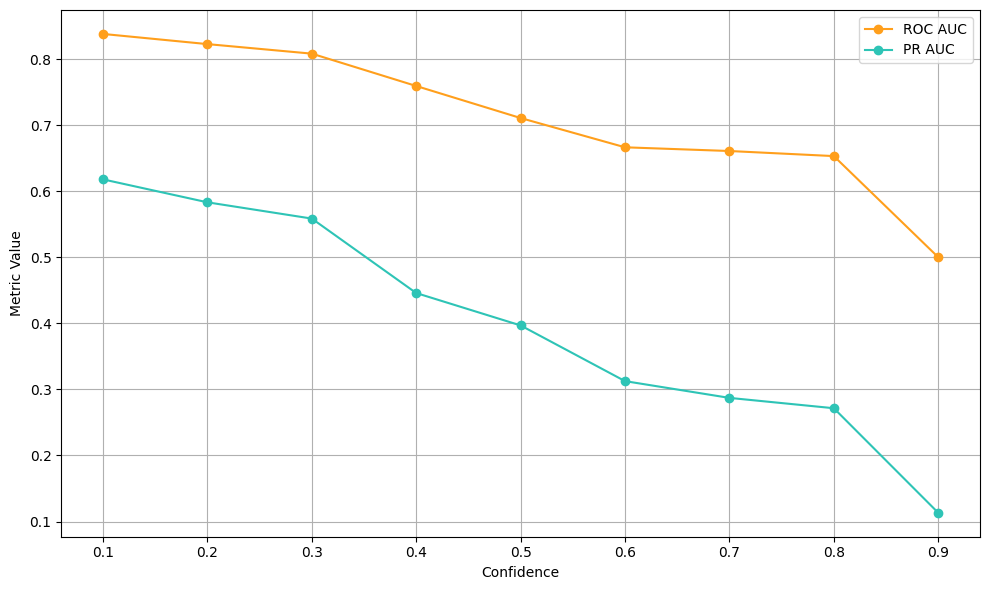

In [107]:
def plot_metrics( df, name, x_col,
                  metric_cols=None,
                  color_scheme=None,
                  force_even_x_spacing=False ):
    if metric_cols is None:
        # Use all columns except the x-axis column if metric_cols not provided
        metric_cols = [ col for col in df.columns if col != x_col ]

    plt.figure( figsize=(10, 6) )

    x_positions = df[ x_col ]
    if force_even_x_spacing:
        x_positions = range( len( df ) )

    # Plot each metric column
    for i, col in enumerate( metric_cols ):
        # Use a color from the color_scheme if provided, cycling if necessary
        color = color_scheme[ i % len( color_scheme ) ] if color_scheme else None
        plt.plot( x_positions, df[ col ], marker="o", label=KEY_MAPPING[ col ], color=color )

    plt.xlabel( KEY_MAPPING[ x_col ] )
    if force_even_x_spacing:
        plt.xticks( x_positions, df[ x_col ] )
    plt.ylabel( "Metric Value" )
    plt.legend()
    plt.grid( True )
    plt.tight_layout()
    plt.savefig( f"plots/metric_progress_{name}", bbox_inches='tight', pad_inches=0.1 )


metric_cols_1 = [ ACC_KEY, PREC_KEY, REC_KEY, F1_KEY ]
metric_cols_2 = [ ROC_KEY, PR_KEY ]

plot_metrics( subgraph_matching_df,
              "subgraph_matching_general",
              CONFIDENCE_KEY,
              color_scheme=ColorScheme.all_high_contrast(),
              metric_cols=metric_cols_1,
              force_even_x_spacing=True )
plot_metrics( subgraph_matching_df,
              "subgraph_matching_auc",
              CONFIDENCE_KEY,
              color_scheme=ColorScheme.all_high_contrast(),
              metric_cols=metric_cols_2,
              force_even_x_spacing=True )

plot_metrics( pattern_matching_df,
              "pattern_matching_general",
              CONFIDENCE_KEY,
              color_scheme=ColorScheme.all_high_contrast(),
              metric_cols=metric_cols_1,
              force_even_x_spacing=True )
plot_metrics( pattern_matching_df,
              "pattern_matching_auc",
              CONFIDENCE_KEY,
              color_scheme=ColorScheme.all_high_contrast(),
              metric_cols=metric_cols_2,
              force_even_x_spacing=True )

## Tables

In [108]:
def filter_by_column_value( df: pd.DataFrame, col: str, value ) -> pd.DataFrame:
    return df.loc[ df[ col ] == value ]


def to_binarized_patterns( df: pd.DataFrame, pattern: str ) -> pd.DataFrame:
    df = df.copy()
    df.loc[ df[ TRUE_KEY ] != pattern, [ TRUE_KEY ] ] = cpg_const.NO_DESIGN_PATTERN
    df.loc[ df[ PRED_KEY ] != pattern, [ PRED_KEY ] ] = cpg_const.NO_DESIGN_PATTERN
    return df


def group_by_col( df: pd.DataFrame, col: str, binarize_patterns=False ) -> dict[ str, pd.DataFrame ]:
    groups: dict[ str, pd.DataFrame ] = { }
    for col_value in list( source_pred_df[ col ].unique() ):
        if binarize_patterns:
            if col_value == cpg_const.NO_DESIGN_PATTERN:
                continue
            groups[ col_value ] = to_binarized_patterns( df, col_value )
        else:
            groups[ col_value ] = filter_by_column_value( df, col, col_value )
    return groups

In [109]:
source_pred_dataset_dfs = group_by_col( source_pred_df, DATASET_KEY )
source_pred_dataset_df_example = source_pred_dataset_dfs[ list( source_pred_dataset_dfs.keys() )[ 0 ] ]
source_pred_dataset_df_example

,gidx,dataset,record,true_type,pred_type,pred_score
0,394,p_mart-11_-_pmd_v18,test.net.sourceforge.pmd.cpd.JavaTokensTokeniz...,N/A,VISITOR,0.367907
1,428,p_mart-11_-_pmd_v18,test.net.sourceforge.pmd.symboltable.NameOccur...,N/A,VISITOR,0.367907
3,397,p_mart-11_-_pmd_v18,net.sourceforge.pmd.PMDException,N/A,VISITOR,0.367936
5,388,p_mart-11_-_pmd_v18,net.sourceforge.pmd.rules.UnusedPrivateMethodRule,N/A,VISITOR,0.616750
8,138,p_mart-11_-_pmd_v18,net.sourceforge.pmd.ast.ASTUnmodifiedClassDecl...,N/A,VISITOR,0.371579
12,312,p_mart-11_-_pmd_v18,net.sourceforge.pmd.renderers.HTMLRenderer,BUILDER,BUILDER,0.847923
13,313,p_mart-11_-_pmd_v18,net.sourceforge.pmd.renderers.SummaryHTMLRenderer,BUILDER,BUILDER,0.847923
14,430,p_mart-11_-_pmd_v18,net.sourceforge.pmd.renderers.IDEAJRenderer,BUILDER,BUILDER,0.862307
15,121,p_mart-11_-_pmd_v18,net.sourceforge.pmd.cpd.XMLRenderer,BUILDER,BUILDER,0.861661
16,283,p_mart-11_-_pmd_v18,net.sourceforge.pmd.renderers.XMLRenderer,BUILDER,BUILDER,0.862307


In [110]:
source_pred_pattern_dfs = group_by_col( source_pred_df, TRUE_KEY, binarize_patterns=True )
source_pred_pattern_df_example = source_pred_pattern_dfs[ list( source_pred_pattern_dfs.keys() )[ 1 ] ]
source_pred_pattern_df_example

,gidx,dataset,record,true_type,pred_type,pred_score
0,394,p_mart-11_-_pmd_v18,test.net.sourceforge.pmd.cpd.JavaTokensTokeniz...,N/A,N/A,0.367907
1,428,p_mart-11_-_pmd_v18,test.net.sourceforge.pmd.symboltable.NameOccur...,N/A,N/A,0.367907
2,1022,p_mart-10_-_nutch_v04,net.nutch.db.DistributedWebDBWriter.LinkInstru...,N/A,N/A,0.609831
3,397,p_mart-11_-_pmd_v18,net.sourceforge.pmd.PMDException,N/A,N/A,0.367936
4,1084,p_mart-10_-_nutch_v04,net.nutch.db.WebDBWriter.DeduplicatingPageSequ...,N/A,N/A,0.609703
...,...,...,...,...,...,...
70,112,p_mart-5_-_junit_v37,junit.extensions.TestDecorator,N/A,N/A,0.883315
71,17,p_mart-5_-_junit_v37,junit.extensions.TestSetup,N/A,N/A,0.527402
72,26,p_mart-5_-_junit_v37,junit.extensions.RepeatedTest,N/A,N/A,0.527402
73,584,p_mart-8_-_mapperxml_v197,com.taursys.servlet.ServletForm,N/A,N/A,0.870310


In [111]:
def get_metric_df( df: pd.DataFrame, name: str, round_to: int = 3 ) -> pd.DataFrame:
    true_labels = df[ TRUE_KEY ].to_list()
    pred_labels = df[ PRED_KEY ].to_list()
    x_labels, y_labels = epm.to_numeric_labels( true_labels, pred_labels )
    metrics = epm.compute_metrics( x_labels, y_labels )

    metric_cols = [ ACC_KEY, PREC_KEY, REC_KEY, F1_KEY, ROC_KEY, PR_KEY ]
    data = [ round( metrics[ METRIC_COMPUTE_MAPPING[ key ] ], round_to ) for key in metric_cols ]
    return pd.DataFrame( [ [ name, *data ] ], columns=[ "Pattern", *metric_cols ] )


def get_metric_df_by_patterns( df: pd.DataFrame, table_name ) -> pd.DataFrame:
    metrics = get_metric_df( df, "All" )
    for pattern, pattern_df in group_by_col( df, TRUE_KEY, binarize_patterns=True ).items():
        if len( pattern_df[ TRUE_KEY ].unique() ) < 2:
            continue
        pattern_metrics = get_metric_df( pattern_df, DESIGN_PATTERN_MAPPING[ pattern ] )
        metrics = pd.concat( [ metrics, pattern_metrics ], ignore_index=True )
    metrics.to_csv( f"tables/metrics_{table_name}.csv", index=False )
    return metrics


all_metrics = get_metric_df_by_patterns( source_pred_df, "all" )
for dataset, dataset_df in source_pred_dataset_dfs.items():
    get_metric_df_by_patterns( source_pred_df, dataset )
all_metrics

,Pattern,Accuracy,Precision,Recall,F1-Score,ROC AUC,PR AUC
0,All,0.772,0.825,0.667,0.613,0.823,0.583
1,Builder,0.946,0.945,0.907,0.916,0.946,0.588
2,Observer,0.900,0.974,0.973,0.972,0.900,0.827
3,Adapter,0.500,0.867,0.867,0.805,0.500,0.133
4,Singleton,0.833,0.974,0.973,0.971,0.833,0.693
5,Prototype,1.000,1.000,1.000,1.000,1.000,1.000
6,Factory Method,0.893,0.973,0.973,0.973,0.893,0.653
7,Memento,0.985,0.979,0.973,0.975,0.985,0.800
8,Proxy,0.993,0.993,0.987,0.989,0.993,0.500
9,Decorator,0.993,0.990,0.987,0.988,0.993,0.750
